# Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

### Step 1: Distortion Correction

#### 1. Finding Corners
Remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

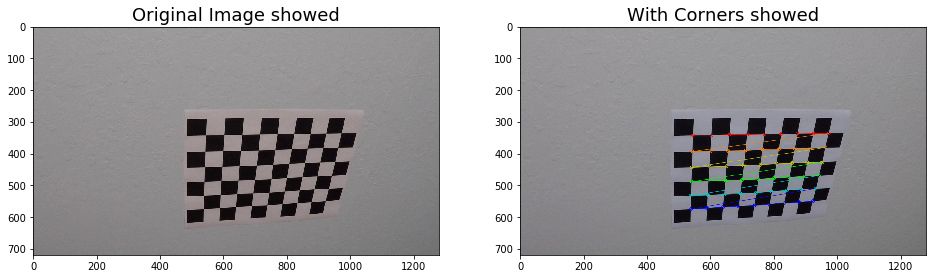

In [2]:
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image showed', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners showed', fontsize=18)
        break

#### 2 Undistortion
Function `undistort()` which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [3]:
# Remove distortion from images
def undistort(image, show=True, read = False):
    if read:
        image = cv2.imread(image)
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image showed', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image showed', fontsize=20)
    return undist

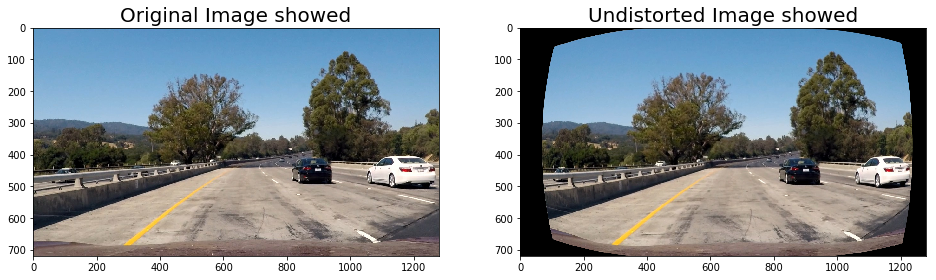

In [4]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image, read = True)
    break

### Step 2: Perspective Transform

Function `birds_eye()` which transforms the undistorted image to a "birds eye view" of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother.

In [5]:
# Perform perspective transform
def birds_eye(img, display = True): 
    h,w = img.shape[:2]

    # define source and destination points for transform
#     src = np.float32([(575,464),
#                       (707,464), 
#                       (258,682), 
#                       (1049,682)])
#     dst = np.float32([(450,0),
#                       (w-450,0),
#                       (450,h),
#                       (w-450,h)])

    src = np.float32([[510, 464],[808, 464],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    

    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image showed', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image showed', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M, Minv

In [ ]:
for image in glob.glob('test_images/test*.jpg'):
    udisImge = undistort(image, False, read = True)
    warped, M, Minv = birds_eye(udisImge, display = True)
    break
    
    

### Step 3: Apply Binary Thresholds

I am using the following color channels and thresholds identifying the lane lines in the provided test images:
- The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
- The L Channel from the HLS color space, with a min threshold of 210 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.

Finnaly create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image.


In [6]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True, read = False):
    if read == True:
        udisImge = undistort(image, False, read = True)
    else:
        udisImge = undistort(image, False)
    img, M, Minv = birds_eye(udisImge, display = False)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    hls_s = hls_s*(255/np.max(hls_s))
    # 2) Apply a threshold to the L channel
    hls_s_binary = np.zeros_like(hls_s)
    hls_s_binary[(hls_s > 180) & (hls_s <= 255)] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    hls_l_binary = np.zeros_like(hls_l)
    hls_l_binary[(hls_l > 210) & (hls_l <= 255)] = 1
    
    
    # Combine HLS L and S channel thresholds
    combined_binary = np.zeros_like(hls_l_binary)
    combined_binary[(hls_l_binary == 1) | (hls_s_binary == 1)] = 1
    

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3,ax4)) = plt.subplots(1, 4,  figsize=(14,5))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(udisImge,cv2.COLOR_BGR2RGB))
        
        ax2.set_title('HLS L binary threshold', fontsize=16)
        ax2.imshow(hls_l_binary, cmap='gray')
        
        ax3.set_title('HLS S binary threshold', fontsize=16)
        ax3.imshow(hls_s_binary, cmap='gray')

        ax4.set_title('Combined color thresholds', fontsize=16)
        ax4.imshow(combined_binary, cmap='gray')
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return combined_binary, Minv

In [ ]:
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image,read = True)
    break

### Steps 4 Sliding Window Ployfit

 Define method to fit polynomial to binary image with lines extracted, using sliding window 

In [7]:
def sliding_window_polyfit(img):
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(img))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(img[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90
    
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position f the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    
    return left_fit, right_fit, left_curverad, right_curverad, center


In [ ]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg_bin, Minv = apply_thresholds(exampleImg, show = False, read = False)
    
left_fit, right_fit, left_curverad, right_curverad, center= sliding_window_polyfit(exampleImg_bin)

# # Create an output image to draw on and  visualize the result
# out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# # Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

udisImge = undistort('./test_images/test2.jpg', False, read = True)
warped, M, Minv = birds_eye(udisImge, display = False)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
f.tight_layout()
ax1.imshow(cv2.cvtColor(udisImge, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image showed', fontsize=20)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and Warped Image showed', fontsize=20)
ax2.plot(left_fitx, ploty, color='red',linewidth=3)
ax2.plot(right_fitx, ploty, color='red',linewidth=3)


Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
this assumes that the fit will not change significantly from one video frame to the next

In [8]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [ ]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test2.jpg')
exampleImg2_bin, Minv = apply_thresholds(exampleImg2,  show = False,  read = False)
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='red')
plt.plot(right_fitx2, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Step 5 Calculate Radius of curvature and distance from Lan Center 

Create method to determine radius of curvature and distance from lane center based on binary image, polynomial fit, and L and R lane pixel indices

In [9]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meter
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)

    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [ ]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

### Step 6 Draw save driving space and radius

Create method to draw safty drving space and plot the radius and center distance on the image

In [10]:
def draw_lane_and_radius(original_img, binary_img, l_fit, r_fit, Minv, curv_rad, center_dist):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    lane_result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    
#     new_img = np.copy(original_img)
    h = lane_result.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(lane_result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(lane_result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    
    return lane_result

In [ ]:
exampleImg_out1 = draw_lane_and_radius(exampleImg, exampleImg_bin, left_fit, right_fit, Minv, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out1)

## Video Processing Pipeline:

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. 

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  
        self.bestx = None     
        self.best_fit = None  
        self.current_fit = []  
        self.radius_of_curvature = None 
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
    def add_fit(self, fit):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

Next I create a function `process_image()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

In [12]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = apply_thresholds(new_img,  show = False,  read = False)

    if not l_line.detected or not r_line.detected:
        l_fit, r_fit,  rad_l, rad_r, d_center = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                           l_lane_inds, r_lane_inds)
    
    l_line.add_fit(l_fit)
    r_line.add_fit(r_fit)
    
    # draw the current best fit if it exists
    if l_fit is not None and r_fit is not None:
        img_out = draw_lane_and_radius(new_img, img_bin,  l_fit, r_fit, Minv, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
        
    global number
    if number == 0:
        import sys
        sys.exit(1)
    number = number -1
    plt.imshow(img_out)

    return img_out


In [ ]:
l_line = Line()
r_line = Line()


video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

* The following is the result of the video pipeline being run on the project video.

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


  1%|▋                                                                                 | 4/485 [00:00<01:19,  6.03it/s]

SystemExit: 1

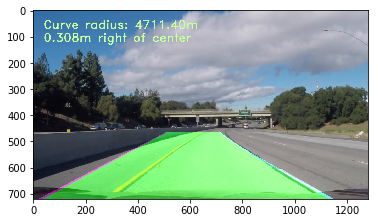

In [13]:
l_line = Line()
r_line = Line()

global number
number = 5
video_output1 = 'challenge_result.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)